# Importing data

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency,shapiro,kruskal,levene,mannwhitneyu

In [2]:
data=pd.read_csv("Taxi_Trip_Data_preprocessed.csv")
data.head(5)

,passenger_count,trip_distance,payment_type,fare_amount,duration
0,1,3.70,Card,24.0,27.950000
1,1,2.77,Card,18.4,19.200000
2,1,3.30,Card,22.6,27.383333
3,1,0.30,Cash,5.1,2.550000
4,1,0.83,Card,7.2,5.250000


# Exploratory Data analysis

In [3]:
data.describe()

,passenger_count,trip_distance,fare_amount,duration
count,8.451090e+06,8.451090e+06,8.451090e+06,8.451090e+06
mean,1.339824e+00,1.751135e+00,1.273180e+01,1.173603e+01
std,7.658024e-01,1.045488e+00,5.346809e+00,6.218064e+00
min,1.000000e+00,1.000000e-02,1.000000e-02,1.666667e-02
25%,1.000000e+00,9.700000e-01,8.600000e+00,6.900000e+00
50%,1.000000e+00,1.500000e+00,1.210000e+01,1.065000e+01
75%,1.000000e+00,2.300000e+00,1.630000e+01,1.561667e+01
max,5.000000e+00,5.230000e+00,4.080000e+01,2.995000e+01


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8451090 entries, 0 to 8451089
Data columns (total 5 columns):
 #   Column           Dtype  
---  ------           -----  
 0   passenger_count  int64  
 1   trip_distance    float64
 2   payment_type     object 
 3   fare_amount      float64
 4   duration         float64
dtypes: float64(3), int64(1), object(1)
memory usage: 322.4+ MB


In [13]:
#checking null values
data.isnull().sum()

passenger_count    0
trip_distance      0
payment_type       0
fare_amount        0
duration           0
dtype: int64

In [15]:
#checking duplicates
data.duplicated().sum()

5557871

In [3]:
#deleting duplicate values
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

In [18]:
#checking no.of passengers
data['passenger_count'].value_counts()

passenger_count
1    1739641
2     659845
3     242397
4     147287
5     104049
Name: count, dtype: int64

In [19]:
#checking payment types
data['payment_type'].value_counts()

payment_type
Card    2095671
Cash     797548
Name: count, dtype: int64

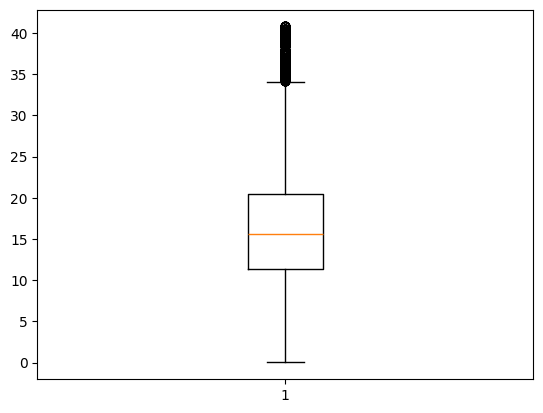

In [20]:
#checking for outliers
plt.boxplot(data['fare_amount'])
plt.show()

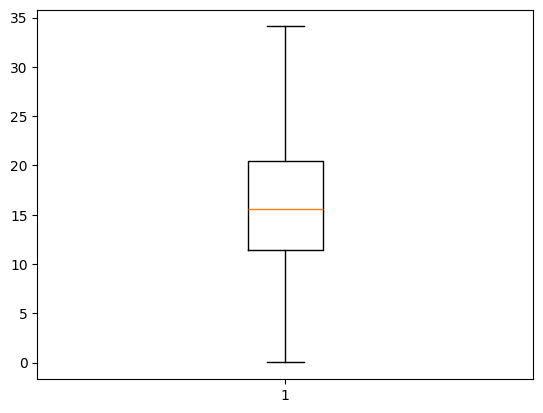

In [4]:
#removing outliers
a=sorted(data['fare_amount'])
q1,q3=np.percentile(a,[25,75])
iqr=q3-q1
l=q1-(1.5*iqr)
h=q3+(1.5*iqr)
data=data[(data['fare_amount']>=l) & (data['fare_amount']<=h)]
plt.boxplot(data['fare_amount'])
plt.show()

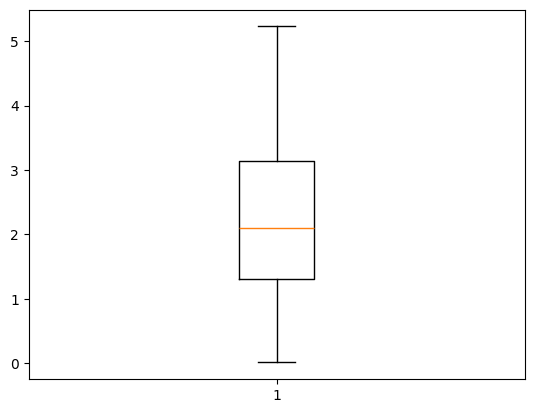

In [51]:
plt.boxplot(data['trip_distance'])
plt.show()

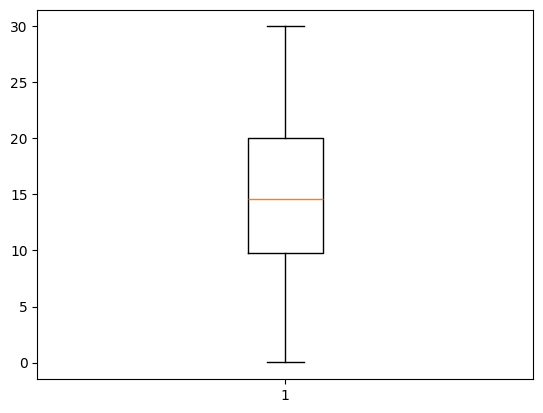

In [52]:

plt.boxplot(data['duration'])
plt.show()

# statistical Analysis

### 1. Payment Type vs Trip Distance

since here we checking whether payment type is dependent on trip distance or not. so we use chi2 test for indepencence

payment type- categoricol col

trip distance - continuous col

we convert trip distnace to caegorical col then we apply test

Short = 0–2 miles

Medium = 2–4 miles

Long = >4 miles

In [5]:
data['distance']=data['trip_distance'].apply(lambda x: 'short' if x<2 else('medium' if ((x>=2) & (x<=4)) else 'long'))


In [6]:
observed=pd.crosstab(data['payment_type'],data['distance'])
observed

distance,long,medium,short
payment_type,,,
Card,266557,935950,892191
Cash,59508,281926,455952


<Axes: xlabel='payment_type'>

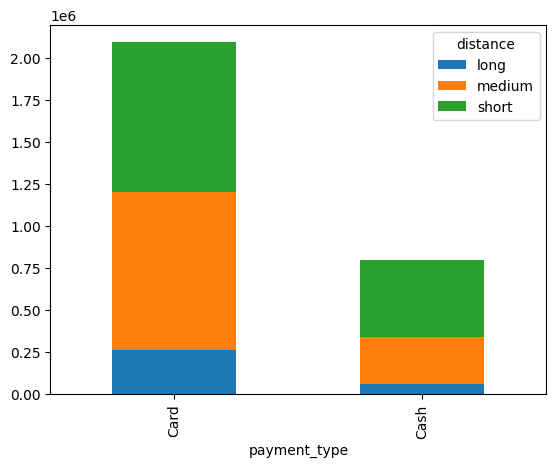

In [55]:
observed.plot(kind='bar',stacked=True)

H0: payment type and distance are independent

H1: payment type and distance are not independent 

In [38]:
chi,p,dof,expected=chi2_contingency(observed)
print(chi)
alpha=0.05
if p<alpha:
    print('reject H0: Payment type and trip distance are NOT independent.')
else:
    print('fail to reject H0: Payment type and trip distance are independent.')

52479.32113996969
reject H0: Payment type and trip distance are NOT independent.


### 2. Does passenger count affect fare amount?

Passenger count = categorical 

Fare amount = continuous

here we can use anova as there is 1 factor(passengers) and its levels are (1,2,3,4,5) before that we need to check whether it is normal or not

<Axes: xlabel='fare_amount', ylabel='Count'>

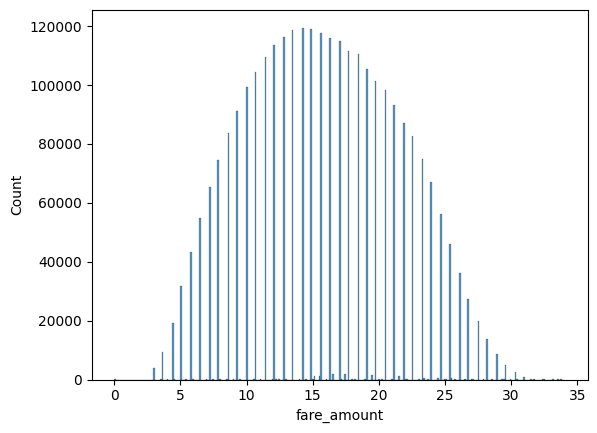

In [8]:
sns.histplot(data['fare_amount'])

In [10]:
s,p=shapiro(data['fare_amount'])
p

1.3703098964138023e-103

since p<0.05 it is not normal so we cant able to use anova rather we use its alternative ie for non parametric Kruskal–Wallis

In [11]:
#making table 1 2 3 4 below that fare amount of those passengers
group={
    1:data[data['passenger_count']==1]['fare_amount'],
    2:data[data['passenger_count']==2]['fare_amount'],
    3:data[data['passenger_count']==3]['fare_amount'],
    4:data[data['passenger_count']==4]['fare_amount'],
    5:data[data['passenger_count']==5]['fare_amount']}

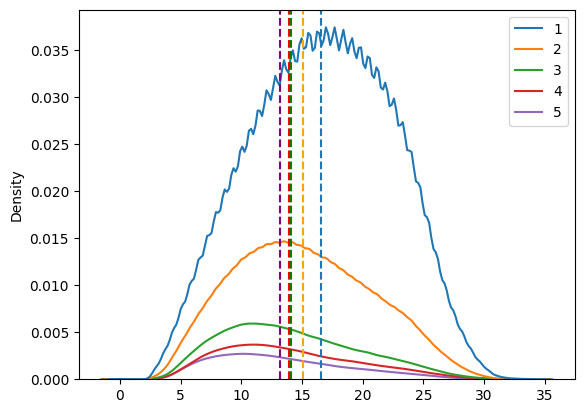

In [113]:
sns.kdeplot(group)

plt.axvline(x=np.mean(group[1]),ls='--')
plt.axvline(x=np.mean(group[2]),ls='--',color='orange')
plt.axvline(x=np.mean(group[3]),ls='--',color='green')
plt.axvline(x=np.mean(group[4]),ls='--',color='red')
plt.axvline(x=np.mean(group[5]),ls='--',color='purple')

H0: Passenger count has no significant effect on fare amount. (ie fares of 1 ,2, 3,4,5 passengers have same mean or distribution ie x1=x2=x3=x4=x5)

H1: significant effect of passenger count on fare amount.

In [39]:
s,p=kruskal(*group.values())
print(s)
alpha = 0.05
if p < alpha:
    print("Reject H0: Passenger count has a significant effect on fare amount.")
else:
    print("Fail to Reject H0: No significant effect of passenger count on fare amount.")

105792.23508407074
Reject H0: Passenger count has a significant effect on fare amount.


### 3. Do short trips generate higher fares per km than long trips?

we geneate 2 samples short and long and use 2 smaple t test

In [21]:
data['fare_per_km'] = data['fare_amount'] / data['trip_distance']
data['distance2']=data['trip_distance'].apply(lambda x: 'short' if x<=3 else 'long')

short=data[data['distance2']=='short']['fare_per_km']
long=data[data['distance2']=='long']['fare_per_km']

In [19]:
#checking for normality and variance
s1,p1=shapiro(short)
s2,p2=shapiro(long)
print(p1)
print(p2)
s,p=levene(short,long)
print(p)

1.3182303332436608e-245
1.0500247425955107e-116
0.0


since normality and variance are below 0.05 we cant use 2 sample t test rather we use its alternative ie mann-whitney u test

h0: Short trips and long trips have the same average fare per km

h1: Short trips and long trips do not have same average fare per km

In [40]:
u,p=mannwhitneyu(short,long)
print(u)
if p < alpha:
    print("Reject H0: Short trips and long trips do not have same average fare per km")
else:
    print("Fail to Reject H0: Short trips and long trips have the same average fare per km")

1483549830858.5
Reject H0: Short trips and long trips do not have same average fare per km
